<a href="https://colab.research.google.com/github/shahad-jeza/kaust_training/blob/main/summer_basic_code/classifing_reviews_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention,GlobalAveragePooling1D

# 1. Data preparation
vocab_size = 10000
max_length = 200
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (25000, 200)
Shape of X_test: (25000, 200)


In [7]:
# 2. Build the RNN model with attention
inputs = Input(shape=(max_length,))
embedding = Embedding(vocab_size, 128)(inputs)
lstm = LSTM(64, return_sequences=True)(embedding)
attention = Attention()([lstm, lstm])
pooling = GlobalAveragePooling1D()(attention)  # Add this layer
dense1 = Dense(64, activation='relu')(pooling)
outputs = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# 3. Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 200, 128)       │      1,280,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 200, 64)        │         49,408 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_4 (Attention)   │ (None, 200, 64)        │              0 │ lstm_4[0][0],          │
│                           │                        │                │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ attention_4[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          4,160 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │             65 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,333,633 (5.09 MB)

 Trainable params: 1,333,633 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 428ms/step - accuracy: 0.7047 - loss: 0.5301 - val_accuracy: 0.8678 - val_loss: 0.3108
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 406ms/step - accuracy: 0.9134 - loss: 0.2268 - val_accuracy: 0.8772 - val_loss: 0.3117
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 406ms/step - accuracy: 0.9483 - loss: 0.1449 - val_accuracy: 0.8794 - val_loss: 0.3191
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 400ms/step - accuracy: 0.9616 - loss: 0.1045 - val_accuracy: 0.8666 - val_loss: 0.3875
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 404ms/step - accuracy: 0.9781 - loss: 0.0631 - val_accuracy: 0.8686 - val_loss: 0.4321


In [8]:
# 4. Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.8538 - loss: 0.4712
Test accuracy: 0.8536


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


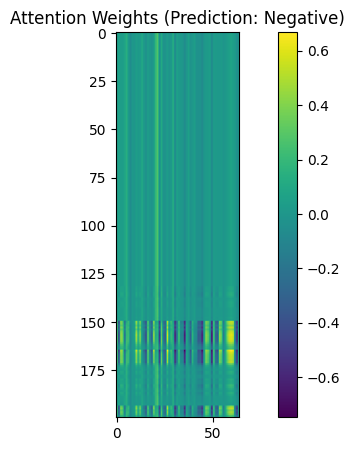

In [9]:
# 5. Visualize attention weights
import matplotlib.pyplot as plt

# Get the attention layer
attention_layer = [layer for layer in model.layers if isinstance(layer, Attention)][0]

# Create a new model that outputs attention weights
attention_model = Model(inputs=model.input, outputs=[model.output, attention_layer.output])

# Get a sample input
sample_index = 0
sample_input = X_test[sample_index:sample_index+1]

# Get the prediction and attention weights
prediction, attention_weights = attention_model.predict(sample_input)

# Plot attention weights
plt.figure(figsize=(10, 5))
plt.imshow(attention_weights[0], cmap='viridis')
plt.title(f"Attention Weights (Prediction: {'Positive' if prediction[0][0] > 0.5 else 'Negative'})")
plt.colorbar()
plt.show()